# Motivation of the Study
A significant amount of $CO_2$ is emitted from surface water bodies such as lakes, streams and wetlands. Hydrologic controls, such as discharge plays crucial role in parttioning between dissolved carbondioxide in water ($pCO_2$) and $CO_2$ evasion. Aside from discharge, surface water and channel characteristics such as velocity, water temperature, catchment slope, groundwater flow, land use, terrestrial to aquatic transport of organic matter etc has important role in shifting the $CO_2$ between its dissolved form and gaseous form by which it goes back to atmosphere, contributing to global $CO_2$ budget. But the current estimates of inland contributed $CO_2$ to atmosphere is poorly constrained due to lack of high frequency sensor data as well as due to the novelty of the processes. The controls on the gas efflux also varies to great extent at spatial and temporal variation. Different reaches across the same river or stream is expected to have large variation in hydrologic parameters that also lead to variation in $CO_2$ efflux and dissolved concentration of the gas. As shown in figure 2, the landsat timelapse over 37 years at a segement of Flint River, GA reveals fluctuations in channel shape over time as well as land use change. These changes can alter the amount of allochthonous carbon input into the river and also can change channel characteristics. Additionally, the hydrologic extreme events, such as storms and precipitation events are not represented by grab sample method of data collection. As pointed out by Raymond et al., (2016), about 86% of dissolved organic carbon is exported during hydrologic events, meaning there are associated response in $CO_2$ dynamic, which are not properly understood yet due to the lack of continuous sensor measurements. To address these knowledge gaps, it is imperative to improve our understanding of the hydrologic controls on $CO_2$ dynamics both at the spatial and temporal scale.      

## Study Objective
Revisiting the surface water $CO_2$ dynamics, addressing the controls with the limited grab sample data available for the selected site

# Site description

The site for this study is Flint River located in Georgia, United States (Figure 1). The river is non-wadable with flowing length of 554 Km (344 Miles). The NEON site (Site ID: FLNT) is located within Jones Ecological Research Center (31.185424, -84.437403; elevation: 30 m). The site has mean annual temperature of 19.2 $^{\circ}$C and mean annual precipitation of 1311 mm. The USGS site is located at Bainbridge, GA (Site ID: 02356000). The NEON site provides grab sample data for *p*$CO_2$ ($\mu$atm) at bimonthly/monomonthly basis, while surface water characteristics data (water temperature, discharge, velocity) at the corresponding time was collected from USGS NWIS.    


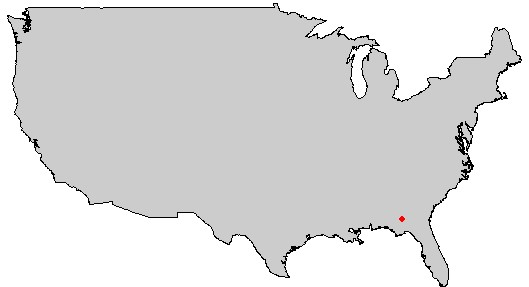
<div style="text-align: center"> Figure 1: Study Site Location (Created with RStudio) </div>
<br>
<br>
<br>
<br>
<br>


<img src="FLNT.gif" style="width:300px;height:300px">
<div style="text-align: center"> Figure 2: Landsat Timelapse for the study site (Credit: Streamlit) </div>



# Reading and Manipulating the Data

The data collected from collection agencies are first to be loaded in python. The necessary python libraries are imported first and then the data are loaded.

In [1]:
# Importing packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from datetime import datetime
from pprint import pprint
import numpy as np                    
from matplotlib import pyplot as plt 
import datetime
import matplotlib.lines as mlines
from datetime import datetime
import math
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import pearsonr

#Creating filenemaes, that are to be later used
filenames = ['FLNT_USGS.txt', 'GHG_final.csv', 'FLNT_discharge.txt']
location = 'Fint River, Georgia'




At this point, several variables are defined for analysis: <br>
the slope of the Flint river is assigned to be 2.4 m/Km (Rugel et al., 2016); <br>
equilibrium Coefficient, $K_hr$ = 0.34 $Matm^-1$ (Tian et al., 2015); <br>
$[CO_2a]$ = 0.012 $mmolL^-1$ (equivalent to an adopted value of  410 ppm ambient $CO_2$ concentration recorded at Mauna Loa (unit conversion is performed as per Kimball (1990).


In [2]:
# Creating Variables for the analysis
slope = 0.0024   #Slope of the catchment, 
khr = 0.34 #(M/atm) equillibrium coefficient
co2_a =390 #unit: micro-atm 
co2_a_mmolperL = 0.012

Now The NEON data, USGS water quality data and USGS discharge data are imported. Since NEON grab sample data is available only from 2017-04-18 to 2020-06-23, this timespan is used to trim all the dataset. The NEON grab samples has been collected at arbitrary time of the day and has been rounded to nearest hour to keep the consistency with USGS dataset. The missing values in USGS dataset is filled in using forward filling interpolation method. 

In [3]:
#%% Reading NEON Data
cols_neon = ['timestamp','site','pCO2_uatm', 'CO2_uM']
neondata = pd.read_csv(filenames[1], usecols=cols_neon,
                     delimiter=',', comment='#', header=0,
                 parse_dates=['timestamp'], na_values = [-9999])

neondata = neondata.rename(columns = {'timestamp': 'date' })

#Rounding the timedate into rounded hours
neondata['date'] = neondata['date'].dt.round(freq='1H')

neondata = neondata.set_index(['date'])


startdates = pd.to_datetime('2017-04-18 00:00')
enddates = pd.to_datetime('2020-06-23 23:30')
neondata = neondata[startdates:enddates]


print(neondata.head(5))


                     site  pCO2_uatm  CO2_uM
date                                        
2017-04-18 14:00:00  FLNT       1833    65.8
2017-04-25 14:00:00  FLNT       2797   101.8
2017-05-09 11:00:00  FLNT       2479    90.0
2017-05-16 10:00:00  FLNT       2877    96.6
2017-06-13 14:00:00  FLNT       3371   111.1


In [4]:
#%%Reading USGS Data [water teperature and velocity]
cols = ['20d','14n','14n.1']

dfusgs_flnt = pd.read_csv(filenames[0], usecols=cols,
              delimiter='\t', comment='#', header=1,
              parse_dates=['20d'], na_values = [-9999])

dfusgs_flnt = dfusgs_flnt.rename(columns={"20d": "date",
                                "14n": "velocity",
                                  "14n.1": "temp"})


dfusgs_flnt = dfusgs_flnt.set_index('date')

#trimming for desired date range
dfusgs_flnt = dfusgs_flnt[startdates:enddates]

#Filling up missing values by forward filling method
dfusgs_flnt = dfusgs_flnt.ffill()


#Merging NEON data and USGS data to contain the data with common date of collection
Merged_data = neondata.join(dfusgs_flnt)

Merged_data['velocity_ms'] = Merged_data.velocity/3.28  #discharge unit m3/sec

print(Merged_data.head(5))


                     site  pCO2_uatm  CO2_uM  velocity  temp  velocity_ms
date                                                                     
2017-04-18 14:00:00  FLNT       1833    65.8      0.63  22.6     0.192073
2017-04-25 14:00:00  FLNT       2797   101.8      0.52  22.2     0.158537
2017-05-09 11:00:00  FLNT       2479    90.0      0.57  22.0     0.173780
2017-05-16 10:00:00  FLNT       2877    96.6      0.40  24.8     0.121951
2017-06-13 14:00:00  FLNT       3371   111.1      0.73  25.6     0.222561


In [5]:
#%% Reading USGS Discharge

cols_discharge = ['20d','14n']

flnt_discharge = pd.read_csv(filenames[2], usecols=cols_discharge,
              delimiter='\t', comment='#', header=1,
              parse_dates=['20d'], na_values = [-9999])

flnt_discharge = flnt_discharge.rename(columns={"20d": "date",
                                "14n": "discharge"})


flnt_discharge = flnt_discharge.set_index('date')
flnt_discharge['discharge_m3s'] = flnt_discharge.discharge/35.315 #discharge unit m3/sec


Merged_data = Merged_data.join(flnt_discharge)

print(Merged_data.head(5))


                     site  pCO2_uatm  CO2_uM  velocity  temp  velocity_ms  \
date                                                                        
2017-04-18 14:00:00  FLNT       1833    65.8      0.63  22.6     0.192073   
2017-04-25 14:00:00  FLNT       2797   101.8      0.52  22.2     0.158537   
2017-05-09 11:00:00  FLNT       2479    90.0      0.57  22.0     0.173780   
2017-05-16 10:00:00  FLNT       2877    96.6      0.40  24.8     0.121951   
2017-06-13 14:00:00  FLNT       3371   111.1      0.73  25.6     0.222561   

                     discharge  discharge_m3s  
date                                           
2017-04-18 14:00:00       85.0       2.406909  
2017-04-25 14:00:00      250.0       7.079145  
2017-05-09 11:00:00       84.2       2.384256  
2017-05-16 10:00:00       44.4       1.257256  
2017-06-13 14:00:00       59.5       1.684836  


# Results



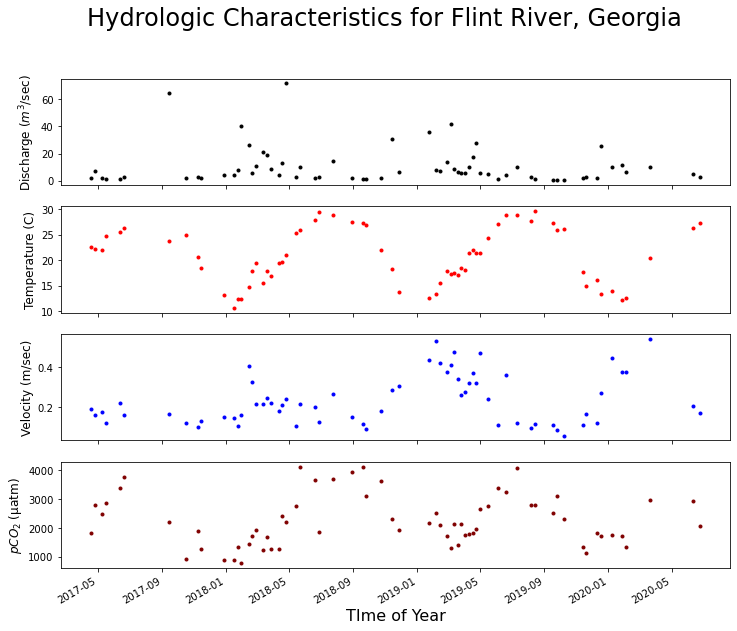

In [11]:
#%% Plot for Hydrologic characteristics
fig1, (ax1,ax2, ax3, ax4) = plt.subplots(4,1, sharex = True, figsize = (12,10))

ax1.plot(Merged_data.index,Merged_data.discharge_m3s, label = 'discharge', color = 'k',
         marker = ".", linestyle = "None")
ax1.set_ylabel('Discharge ($m^3$/sec)', color='k', size = 12)   
# ax1.set_ylim(bottom = 0, top = 30)


ax2.plot(Merged_data.index,Merged_data.temp, label = 'temperature', color = 'r', 
         marker = ".", linestyle = "None")
ax2.set_ylabel('Temperature (C)', color='k', size = 12)   

ax3.plot(Merged_data.index,Merged_data.velocity_ms, label = 'velocity (m/sec)', color = 'blue', 
         marker = ".", linestyle = "None")
ax3.set_ylabel('Velocity (m/sec)', color='k', size = 12)  


ax4.plot(Merged_data.index,Merged_data.pCO2_uatm, label = 'pCO2', color = 'maroon', 
         marker = ".", linestyle = "None")
ax4.set_ylabel('$pCO_2$ (\u03BCatm)', color='k', size = 12)


fig1.suptitle('Hydrologic Characteristics for Flint River, Georgia', size = 24)
fig1.autofmt_xdate()
ax4.set_xlabel('TIme of Year', color='k', size = 16)
plt.show()


The initial hydrological parameters for Flint River are plotted. Qualitatively, *p*$CO_2$ appears to be strongly related to water temperature, as both parameters are showing consistent fluctuation in similar manner over time. This can be attributed to higher metabolic activity in the river at higher temperature and vice versa, leading to increase and decrease of *p*$CO_2$ respectively. Conversely, discharge appears to be seemingly negatively related to *p*$CO_2$. This also seems reasonable, as with the increase in discharge, water turbulance also increases which can contribute to higher degassing of $CO_2$ from water, resulting in decrease in *p*$CO_2$. 

To verify this further, Schmidt Number (N), normalized gas transfer velocity of $CO_2$ with respect to the same at Schmidt number of 600 ($K_600$), $CO_2$ transfer velocity ($K_deg$), Henry's law equilibrium coefficient ($K_h$) and $CO_2$ efflux (i.e., degassing) (gC/$m^2$-day) are calculated based on the analysis by Tian et al., (2015); Liu and Raymond (2018); Rocher-Ros et al., (2019); Raymond et al., (2012).

In [7]:
#%% Calculating the Evasion Flux from surface water
Merged_data['schmidtN'] = 1911.1-118.11*Merged_data.temp + 3.4527 * Merged_data.temp**2 - .04132*Merged_data.temp**3
Merged_data['k600'] = slope * Merged_data.velocity * 2841.6 + 2.03  #Unit: m/day
Merged_data['kdeg'] = Merged_data.k600 * (Merged_data.schmidtN/600)**-0.5 #Unit:m/day
Merged_data['kh'] = khr * np.exp(2400*((1/(Merged_data.temp+273))-1/298)) #unit in M/atm
Merged_data['co2_mmolperL'] = Merged_data.CO2_uM/1000  #converting co2 conc from micromol/l to mmol/l
Merged_data['co2_evasion'] = ((Merged_data.co2_mmolperL - co2_a_mmolperL) * Merged_data.kdeg *12) #Unit: gC/m2/day
print(Merged_data.head(5))


                     site  pCO2_uatm  CO2_uM  velocity  temp  velocity_ms  \
date                                                                        
2017-04-18 14:00:00  FLNT       1833    65.8      0.63  22.6     0.192073   
2017-04-25 14:00:00  FLNT       2797   101.8      0.52  22.2     0.158537   
2017-05-09 11:00:00  FLNT       2479    90.0      0.57  22.0     0.173780   
2017-05-16 10:00:00  FLNT       2877    96.6      0.40  24.8     0.121951   
2017-06-13 14:00:00  FLNT       3371   111.1      0.73  25.6     0.222561   

                     discharge  discharge_m3s    schmidtN      k600      kdeg  \
date                                                                            
2017-04-18 14:00:00       85.0       2.406909  528.351020  6.326499  6.741830   
2017-04-25 14:00:00      250.0       7.079145  538.602565  5.576317  5.885574   
2017-05-09 11:00:00       84.2       2.384256  543.811440  5.917309  6.215495   
2017-05-16 10:00:00       44.4       1.257256  475.2669

## Understanding the drivers of $CO_2$ partitioning

To visualize the response of $pCO_2$, $k_{600}$ and $CO_2$ evasion flux with respect to discharge, each response parameters are plotted against discharge. At low discharge (0-5 $m^3/sec$), the dominant state of $CO_2$ is $pCO_2$ rather than $CO_2$ evasion. This implies, at this low flow condition, $CO_2$ evasion is transfer limited. The higher $pCO_2$ at low flow condition could also be due to higher residence time, allowing enhanced metabolic activities. The partitioning at high flow condition is not very obvious, due to unavailability of $pCO_2$  data. $k_{600}$ tends to increase with high discharge condition as for obvious reason of high turbulence associated with high flow. 

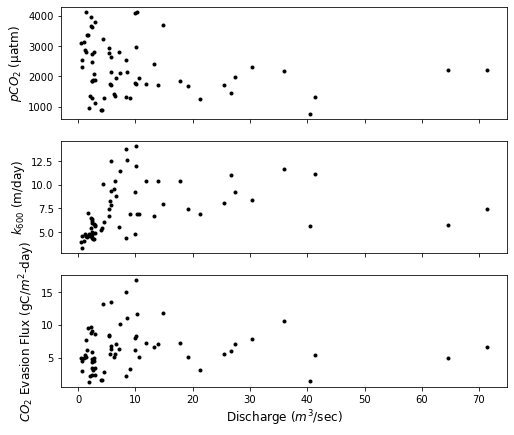

In [8]:
#%% Variation of CO2 parameters wrt Discharge
fig3, (ax1, ax2, ax3) = plt.subplots(3,1, sharex = True, figsize = (8,7))
ax1.plot(Merged_data.discharge_m3s, Merged_data.pCO2_uatm, '.', label = 'discharge-pCO2', color = 'black')
ax1.set_ylabel('$pCO_2$ (\u03BCatm)', color='k', size = 12)

ax2.plot(Merged_data.discharge_m3s, Merged_data.k600, '.', label = 'discharge-k600', color = 'black')
ax2.set_ylabel('$k_{600}$ (m/day)', color='k', size = 12)

ax3.plot(Merged_data.discharge_m3s, Merged_data.co2_evasion, '.', label = 'discharge-evasion', color = 'black')
ax3.set_ylabel('$CO_2$ Evasion Flux (gC/$m^2$-day)', color='k', size = 12)
ax3.set_xlabel('Discharge ($m^3$/sec)', color='k', size = 12)   
plt.show()


At lower $k_{600}$, i.e., when the water is less turbulent, $pCO_2$ is higher and evasion flux is lower. The opposite is true for high turbulent condition, meaning evasion is supply limited at turbulent condition. The wide variation of $pCO_2$ at low $k_{600}$ could be due to metabolic activity and/or allochthonous organic matter supply (Rocher-Ros et al., 2019).

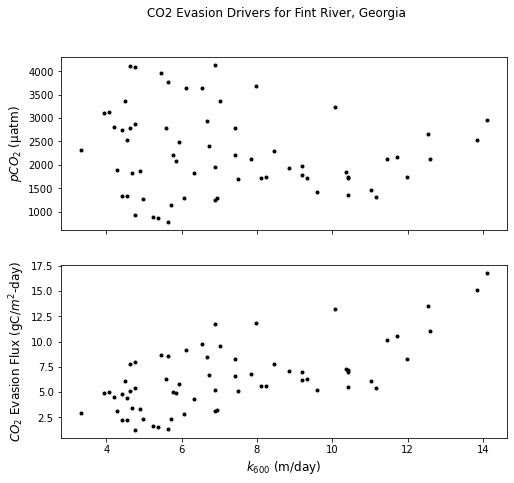

In [9]:
#%% Variation of pCO2 and CO2 evasion wrt K600
fig5, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize = (8,7))
ax1.plot(Merged_data.k600, Merged_data.pCO2_uatm, '.', label = 'k600-pCO2', color = 'black')
ax1.set_ylabel('$pCO_2$ (\u03BCatm)', color='k', size = 12)

ax2.plot(Merged_data.k600, Merged_data.co2_evasion, '.', label = 'Velocity-k600', color = 'black')
ax2.set_ylabel('$CO_2$ Evasion Flux (gC/$m^2$-day)', color='k', size = 12)


ax2.set_xlabel('$k_{600}$ (m/day)', color='k', size = 12)   
fig5.suptitle('CO2 Evasion Drivers for '+str(location))
plt.show()


The pearson correlation coefficients were determined and plotted into a heatmap to visualize the relative dependence between parameters and dominant state of $CO_2$ in water. Temperature was highly positively correlated with $pCO_2$ ($r^2$ = 0.73) while discharge was moderately negativly correlated ($r^2$ = $-$0.21). $k_{600}$ is strongly correlated to $CO_2$ evasion ($r^2$ = 0.66).

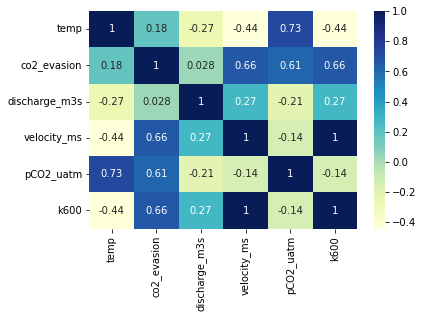

In [10]:
#%% Heatmap plot for determining any correlation 
fff = pd.DataFrame([Merged_data["temp"], Merged_data["co2_evasion"],
                    Merged_data['discharge_m3s'], Merged_data['velocity_ms'],
                    Merged_data['pCO2_uatm'], Merged_data['k600']]).unstack().unstack()

fig2 = sns.heatmap(fff.corr(), cmap="YlGnBu", annot = True)
plt.show()


## Concluding Remarks

Despite having limited $pCO_2$ grab sample data, consistent results were found between river discharge - evasion (chemostatic, aho et al., (2021); $k_{600}$ - evasion ($r^2$ = 0.66);  $k_{600}$ - $pCO_2$ ($r^2$ = - 0.14). It was not possible to identify the response of extreme events on the $CO_2$ dynamics due to unavailability of continuous sensor measurements. It is of great interest to utilize the automated sensor data as soon as they are available. To the best of author's knowledge, NEON is deploying sensors at at least two site: CARI and MART and the data are currently at QA stage. The author also aspires to better understand the transport of terrestrial carbon to streams and river, preferably by modifying existing models or making a simple model. Although already stated that measurement of real time automated dissolved $CO_2$ concentration is highly anticipated to help us understand the response of hydrologic events, the input of carbon to the streams and river is also not constrained properly, as the input can be through groundwater transport, rock weathering or tranport over the land. Thusly, better representation of these transport processes in models also demands attention on par with availability of high frequency data.

# References

Aho, K. S., Fair, J. H., Hosen, J. D., Kyzivat, E. D., Logozzo, L. A., Rocher‐Ros, G., ... & Raymond, P. A. (2021). Distinct concentration‐discharge dynamics in temperate streams and rivers: CO2 exhibits chemostasis while CH4 exhibits source limitation due to temperature control. Limnology and Oceanography, 66(10), 3656-3668.

Kimball, B. A. (1990). Impact of carbon dioxide, trace gases, and climate change on global agriculture: proceedings of a symposium. American Society of Agronomy.

Liu, S., & Raymond, P. A. (2018). Hydrologic controls on pCO2 and CO2 efflux in US streams and rivers. Limnology and Oceanography Letters, 3(6), 428-435.

Tian, H., Yang, Q., Najjar, R. G., Ren, W., Friedrichs, M. A., Hopkinson, C. S., & Pan, S. (2015). Anthropogenic and climatic influences on carbon fluxes from eastern North America to the Atlantic Ocean: A process‐based modeling study. Journal of Geophysical Research: Biogeosciences, 120(4), 757-772.

Raymond, P. A., Zappa, C. J., Butman, D., Bott, T. L., Potter, J., Mulholland, P., ... & Newbold, D. (2012). Scaling the gas transfer velocity and hydraulic geometry in streams and small rivers. Limnology and Oceanography: Fluids and Environments, 2(1), 41-53.

Rocher‐Ros, G., Sponseller, R. A., Lidberg, W., Mörth, C. M., & Giesler, R. (2019). Landscape process domains drive patterns of CO2 evasion from river networks. Limnology and Oceanography Letters, 4(4), 87-95.

RStudio Team (2020). RStudio: Integrated Development for R. RStudio, PBC, Boston, MA URL http://www.rstudio.com/

Rugel, K., Golladay, S. W., Jackson, C. R., & Rasmussen, T. C. (2016). Delineating groundwater/surface water interaction in a karst watershed: Lower Flint River Basin, southwestern Georgia, USA. Journal of Hydrology: Regional Studies, 5, 1-19.

Streamlit for Geospatial Applications (https://streamlit.gishub.org/)

